In [64]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import os

# Mount Google Drive
drive.mount('/content/drive')

# Replace 'df.csv' with the actual path to your file in Google Drive if it's not in the root directory
file_path = '/content/drive/My Drive/data.xlsx'

# 读取数据，time列解析为日期但不设为索引
df1 = pd.read_excel(file_path, parse_dates=['time'])

display(df1.tail(7))
print(df1.dtypes)
print(df1.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,time,ln_gdp_sa,ln_gdp_seasonal_factor,dln_gdp_sa,city_mean_light,region_mean_light,ln_city,ln_region,GDP,ln_gdp,pc1,pc2,pc3,dpc2,quarter,dln_city,dln_region
57,2023-07-01,9.065151,-0.056848,0.006600,23.671801,2.823828,3.164284,1.038093,8170.65,9.008304,0.218038,-0.086089,0.038159,0.081531,3,0.123616,0.054654
58,2023-10-01,9.078985,0.145076,0.013833,23.374365,2.889727,3.151640,1.061162,10138.15,9.224061,-0.126969,-0.025977,-0.039365,0.060112,4,-0.012645,0.023069
59,2024-01-01,NaN,-0.077646,NaN,20.412995,2.599787,3.016172,0.955429,8314.98,9.025814,-0.340136,-0.068752,-0.013587,-0.042775,1,-0.135468,-0.105733
60,2024-04-01,NaN,-0.007745,NaN,19.784729,2.367619,2.984910,0.861885,8987.24,9.103561,0.463105,-0.189923,0.065931,-0.121171,2,-0.031261,-0.093544
61,2024-07-01,NaN,-0.056848,NaN,23.956838,3.014495,3.176254,1.103432,8632.06,9.063238,-0.217543,-0.215419,0.043802,-0.025495,3,0.191343,0.241547
62,2024-10-01,NaN,0.145076,NaN,23.213998,2.998758,3.144755,1.098198,10867.59,9.293540,-0.420393,-0.176598,0.008674,0.038820,4,-0.031498,-0.005234
63,2025-01-01,NaN,-0.077646,NaN,22.387323,2.792224,3.108495,1.026839,8950.49,9.099464,-0.000561,-0.158594,-0.012403,0.018004,1,-0.036261,-0.071360


time                      datetime64[ns]
ln_gdp_sa                        float64
ln_gdp_seasonal_factor           float64
dln_gdp_sa                       float64
city_mean_light                  float64
region_mean_light                float64
ln_city                          float64
ln_region                        float64
GDP                              float64
ln_gdp                           float64
pc1                              float64
pc2                              float64
pc3                              float64
dpc2                             float64
quarter                            int64
dln_city                         float64
dln_region                       float64
dtype: object
(64, 17)


In [65]:
# 1. 数据准备
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
import pickle
warnings.filterwarnings('ignore')

pickle_file_path = '/content/drive/My Drive/stl_deseasonalizer.pkl'
deseasonalizer = pickle.load(open(pickle_file_path, 'rb'))

df = df1[['time', 'ln_gdp_sa', 'ln_gdp_seasonal_factor', 'dln_gdp_sa', 'ln_gdp', 'pc1', 'pc3', 'dpc2', 'dln_city', 'dln_region']].copy()
df = df.set_index('time')

seasonal_factors = deseasonalizer['seasonal_factors'].copy()
seasonal_factors.index = pd.to_datetime(seasonal_factors.index)
# quarterly_averages = deseasonalizer['quarterly_averages'] # No longer needed for this method

missing_dates = df.index[df.index > seasonal_factors.index.max()]
estimated_seasonal_factors = pd.Series(index=missing_dates)

# Calculate the last seasonal factor for each quarter
last_seasonal_factors_by_quarter = seasonal_factors.groupby(seasonal_factors.index.quarter).tail(1)

for date in missing_dates:
    # Use the last available seasonal factor for the corresponding quarter
    quarter = date.quarter
    # Access using the label index (quarter number)
    estimated_seasonal_factors[date] = last_seasonal_factors_by_quarter.loc[last_seasonal_factors_by_quarter.index.quarter == quarter].iloc[0]

combined_seasonal_factors = pd.concat([seasonal_factors, estimated_seasonal_factors])

aligned_df, aligned_seasonal_factors = df.align(combined_seasonal_factors, join='left', axis=0)
# For dates where ln_gdp_sa is NaN, calculate it by adding ln_gdp and the estimated seasonal factor
aligned_df['ln_gdp_sa'] = np.where(aligned_df['ln_gdp_sa'].isnull(),
                                    aligned_df['ln_gdp'] + aligned_seasonal_factors,
                                    aligned_df['ln_gdp_sa'])

aligned_df['dln_gdp_sa'] = aligned_df['ln_gdp_sa'].diff()
df.update(aligned_df)
df['ln_gdp_seasonal_factor'] = aligned_seasonal_factors

df = df.reset_index()
display(df.tail(7))
print(df.dtypes)
print(df.shape)

,time,ln_gdp_sa,ln_gdp_seasonal_factor,dln_gdp_sa,ln_gdp,pc1,pc3,dpc2,dln_city,dln_region
57,2023-07-01,9.065151,-0.056848,0.006600,9.008304,0.218038,0.038159,0.081531,0.123616,0.054654
58,2023-10-01,9.078985,0.145076,0.013833,9.224061,-0.126969,-0.039365,0.060112,-0.012645,0.023069
59,2024-01-01,8.948168,-0.077646,-0.130817,9.025814,-0.340136,-0.013587,-0.042775,-0.135468,-0.105733
60,2024-04-01,9.095816,-0.007745,0.147648,9.103561,0.463105,0.065931,-0.121171,-0.031261,-0.093544
61,2024-07-01,9.006391,-0.056848,-0.089425,9.063238,-0.217543,0.043802,-0.025495,0.191343,0.241547
62,2024-10-01,9.438616,0.145076,0.432225,9.293540,-0.420393,0.008674,0.038820,-0.031498,-0.005234
63,2025-01-01,9.021817,-0.077646,-0.416799,9.099464,-0.000561,-0.012403,0.018004,-0.036261,-0.071360


time                      datetime64[ns]
ln_gdp_sa                        float64
ln_gdp_seasonal_factor           float64
dln_gdp_sa                       float64
ln_gdp                           float64
pc1                              float64
pc3                              float64
dpc2                             float64
dln_city                         float64
dln_region                       float64
dtype: object
(64, 10)


In [66]:
# 1. 数据准备
target = 'dln_gdp_sa'
base_vars = ['pc1', 'pc3', 'dpc2', 'dln_city', 'dln_region']
max_lag = 4

# Create lagged variables for the target variable
for i in range(1, max_lag + 1):
    df[f'{target}_lag{i}'] = df[target].shift(i)

# Create lagged variables for the base variables
for var in base_vars:
    for i in range(1, max_lag + 1):
        df[f'{var}_lag{i}'] = df[var].shift(i)

# Reset index if needed
# df = df.reset_index() # This line is not needed as index was not set in this cell

print(df.shape)

(64, 34)


# Task
Import the AR3, ARIMAX1, ARIMAX2, ARIMAX3, ARIMAX4, ARIMAX5, ARIMAX6, and ARIMAX7 models from "/content/drive/My Drive/Desktop Outputs" and use them to predict the 'dln_gdp_sa' column in the dataframe `df`.

In [67]:
model_paths = [
    '/content/drive/My Drive/Desktop Outputs/AR3.pkl',
    '/content/drive/My Drive/Desktop Outputs/ARIMAX4.pkl',
    '/content/drive/My Drive/Desktop Outputs/RF7.pkl',
    '/content/drive/My Drive/Desktop Outputs/xgb5.pkl',
    '/content/drive/My Drive/GRU_Models/GRU3_7.keras',
    '/content/drive/My Drive/CNN_models/CNN22_2.keras'
]

print(model_paths)

['/content/drive/My Drive/Desktop Outputs/AR3.pkl', '/content/drive/My Drive/Desktop Outputs/ARIMAX4.pkl', '/content/drive/My Drive/Desktop Outputs/RF7.pkl', '/content/drive/My Drive/Desktop Outputs/xgb5.pkl', '/content/drive/My Drive/GRU_Models/GRU3_7.keras', '/content/drive/My Drive/CNN_models/CNN22_2.keras']


In [68]:
loaded_models = {}

for file_path in model_paths:
    model_name = os.path.basename(file_path).split('.')[0] # Get model name without extension
    if file_path.endswith('.pkl'):
        # Check if the model name starts with 'RF', if so use joblib
        if model_name.startswith('RF'):
            import joblib
            try:
                model = joblib.load(file_path)
            except Exception as e:
                print(f"Error loading model {model_name} with joblib: {e}")
                model = None # Set model to None if loading fails
        else: # Assume other .pkl files were saved with pickle
            with open(file_path, 'rb') as f:
                model = pickle.load(f)

        # Add a check here if the loaded object is a model with a predict method
        if model is not None and not hasattr(model, 'predict'):
             print(f"Warning: Loaded object for {model_name} does not have a predict method. Type: {type(model)}")
             # If it's not a model, maybe skip it or handle appropriately
             # For now, let's still store it but the prediction will fail later
        elif model is None:
             print(f"Warning: Model {model_name} could not be loaded.")

    elif file_path.endswith('.keras'):
        import tensorflow as tf
        try:
            model = tf.keras.models.load_model(file_path)
        except Exception as e:
             print(f"Error loading model {model_name} with tf.keras.models.load_model: {e}")
             model = None
    else:
        print(f"Skipping unsupported file type: {file_path}")
        continue # Skip to the next file if the type is not supported

    if model is not None:
        loaded_models[model_name] = model

print(loaded_models.keys())
# Print types of loaded models to verify
for name, model in loaded_models.items():
    print(f"Model '{name}' loaded as type: {type(model)}")

dict_keys(['AR3', 'ARIMAX4', 'RF7', 'xgb5', 'GRU3_7', 'CNN22_2'])
Model 'AR3' loaded as type: <class 'statsmodels.tsa.arima.model.ARIMAResultsWrapper'>
Model 'ARIMAX4' loaded as type: <class 'statsmodels.tsa.arima.model.ARIMAResultsWrapper'>
Model 'RF7' loaded as type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Model 'xgb5' loaded as type: <class 'xgboost.sklearn.XGBRegressor'>
Model 'GRU3_7' loaded as type: <class 'keras.src.models.sequential.Sequential'>
Model 'CNN22_2' loaded as type: <class 'keras.src.models.sequential.Sequential'>


## Prepare prediction data

### Subtask:
Ensure the `df` DataFrame is in the correct format and contains all the necessary lagged variables and exogenous features required by the ARIMAX models for making predictions. Handle any leading `NaN` values introduced by lagging, potentially by dropping rows.


**Reasoning**:
Inspect the dataframe for NaN values and remove leading rows with NaNs to prepare for model prediction.



In [83]:
df_cleaned = df.dropna()

# 3. Verify that the remaining rows in df have no NaN values.
print(df.shape)
print(df_cleaned.shape)
df1 = df_cleaned.copy()

(64, 34)
(59, 34)


In [86]:
# Print df columns and tail before creating prediction_data
# Removed debugging print statements as requested
# print("Columns of df before creating prediction_data:")
# print(df.columns.tolist())
# print("\nTail of df before creating prediction_data:")
# display(df.tail(10))

# Redefine prediction_data_full to be the last 5 rows of df
prediction_data_full = df.tail(5).copy()
# Set the time column as index for easier slicing by date
prediction_data_full = prediction_data_full.set_index('time')


# Removed debugging print statements as requested
# print(f"\nShape of prediction data (full 5 steps): {prediction_data_full.shape}")


predictions = {}

# Define the exact features used by each model based on user input
ar3_features = ['dln_gdp_sa_lag1', 'dln_gdp_sa_lag2', 'dln_gdp_sa_lag3']
arimax4_exog_features = ['pc3_lag4', 'dln_gdp_sa_lag1', 'dln_gdp_sa_lag4', 'dpc2_lag4']
rf7_features = ['dln_gdp_sa_lag3', 'dln_gdp_sa_lag2', 'dln_region_lag2', 'pc3_lag3', 'dln_city_lag2', 'dpc2_lag3', 'dpc2_lag1']
xgb5_features = ['dln_region_lag2', 'dln_gdp_sa_lag2', 'pc1_lag4', 'pc3_lag3', 'pc3_lag1']


# Combine all features needed for all models to ensure they are available in prediction_data_full
all_required_features = list(set(ar3_features + arimax4_exog_features + rf7_features + xgb5_features))

# Check if all required features are present in prediction_data_full
missing_required_features = [f for f in all_required_features if f not in prediction_data_full.columns]
if missing_required_features:
     print(f"Error: Missing required features in prediction data: {missing_required_features}")
     print("Cannot proceed with prediction as not all necessary lagged variables are available in the data.")
     # Stop execution or handle appropriately
else:
    # Impute NaN values in prediction_data_full for features required by tree models using ffill
    features_to_impute = list(set(rf7_features + xgb5_features))

    # Print NaN count *before* imputation
    # Removed debugging print statements as requested
    # print(f"\nNaN count in features to impute *before* imputation:")
    # print(prediction_data_full[features_to_impute].isnull().sum())


    prediction_data_full[features_to_impute] = prediction_data_full[features_to_impute].fillna(method='ffill')

    # Verify imputation
    # Removed debugging print statements as requested
    # print(f"\nNaN count in features to impute *after* imputation:")
    # print(prediction_data_full[features_to_impute].isnull().sum())


    # Proceed with prediction for each model
    models_to_predict = ['AR3', 'ARIMAX4', 'RF7', 'xgb5']

    for model_name, model in loaded_models.items():
        if model_name in models_to_predict: # Only predict for the specified models
            try:
                if model_name == 'AR3':
                    # AR3 uses only lagged target variables as its features (endogenous)
                    # For statsmodels AR model forecast, we don't explicitly pass lagged target as exog.
                    # The model uses its internal state from the training data.
                    # We only need to specify the number of steps to forecast.
                     n_forecast_steps = len(prediction_data_full)
                     forecast_result = model.forecast(steps=n_forecast_steps)

                elif model_name.startswith('ARIMAX'):
                    # ARIMAX uses lagged target (implicitly) and specified exogenous features
                    n_forecast_steps = len(prediction_data_full)
                    # Select the exact exogenous features specified by the user
                    exog_data_pred = prediction_data_full[arimax4_exog_features]

                    # For statsmodels, the forecast method expects the exogenous data for the steps being forecasted.
                    # The columns should ideally match the names the model was trained with.
                    # Since the user specified the exact variables, let's assume these are the ones
                    # the ARIMAX4 model expects as its exogenous inputs, possibly renamed internally to x1, x2 etc.
                    # However, providing them with original names might work, or we might need to rename them
                    # to 'x1', 'x2', 'x3', 'x4' in the correct order. Let's try providing them with original names first.

                    # Check expected exogenous names from the model for confirmation (for debugging if needed)
                    # expected_exog_names = model.model.exog_names
                    # print(f"\nExpected exogenous names for {model_name}: {expected_exog_names}")
                    # print(f"Provided exogenous columns for {model_name}: {exog_data_pred.columns.tolist()}")


                    # If the model expects 'x1', 'x2', etc., we need to rename the columns
                    # Assuming the order in arimax4_exog_features matches the order for x1, x2, x3, x4
                    # This is an assumption based on the user providing the list in a specific order.
                    expected_exog_names_from_model = [name for name in model.model.exog_names if name != 'const']
                    if len(expected_exog_names_from_model) == len(arimax4_exog_features):
                         # Rename exog_data_pred columns to match the model's expected names (x1, x2, etc.)
                         exog_data_pred.columns = expected_exog_names_from_model
                         # Removed debugging print statements as requested
                         # print(f"Renamed exogenous columns for {model_name}: {exog_data_pred.columns.tolist()}")

                    forecast_result = model.forecast(steps=n_forecast_steps, exog=exog_data_pred)


                elif model_name == 'RF7':
                     # RF7 uses specified lagged and base variables as features
                     features = rf7_features
                     # NaNs should be imputed by now, but a final check doesn't hurt
                     if prediction_data_full[features].isnull().sum().sum() > 0:
                          print(f"Warning: NaNs still present in RF7 features after imputation.")
                     X_pred = prediction_data_full[features]
                     forecast_result = model.predict(X_pred)

                elif model_name == 'xgb5':
                     # xgb5 uses specified lagged and base variables as features
                     features = xgb5_features
                      # NaNs should be imputed by now, but a final check doesn't hurt
                     if prediction_data_full[features].isnull().sum().sum() > 0:
                          print(f"Warning: NaNs still present in xgb5 features after imputation.")
                     X_pred = prediction_data_full[features]
                     forecast_result = model.predict(X_pred)

                # Convert forecast_result to a list and store
                if hasattr(forecast_result, 'tolist'):
                    predictions[model_name] = forecast_result.tolist()
                elif isinstance(forecast_result, np.ndarray):
                     predictions[model_name] = forecast_result.flatten().tolist()
                else:
                     predictions[model_name] = list(forecast_result)

            except Exception as e:
                print(f"Error predicting with {model_name}: {e}")
                predictions[model_name] = [np.nan] * len(prediction_data_full) # Fill with NaN if prediction fails


    else:
        # Removed the misplaced continue statement
        pass


# Display the predictions
for model_name, prediction_values in predictions.items():
    print(f"Predictions for {model_name}:")
    if prediction_values:
        for i, value in enumerate(prediction_values):
            print(f"Step {i+1}: {value:.4f}")
    else:
        print("Prediction failed.")
    print("-" * 20)

Predictions for AR3:
Step 1: 0.0389
Step 2: 0.0208
Step 3: 0.0230
Step 4: 0.0257
Step 5: 0.0249
--------------------
Predictions for ARIMAX4:
Step 1: 0.0411
Step 2: 0.0941
Step 3: -0.0309
Step 4: 0.0705
Step 5: -0.1451
--------------------
Predictions for RF7:
Step 1: 0.0328
Step 2: 0.0217
Step 3: 0.0158
Step 4: 0.0221
Step 5: -0.0121
--------------------
Predictions for xgb5:
Step 1: -0.1053
Step 2: 0.0151
Step 3: 0.0435
Step 4: 0.0144
Step 5: 0.0041
--------------------


In [103]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler # Use MinMaxScaler as requested
import tensorflow as tf # Ensure tensorflow is imported for Keras models
# import joblib # No longer needed


# Define the split point
split_date = '2024-01-01'

# Select data before the split point (used for creating input sample and fitting scaler)
data_before_split = df1[df1['time'] < split_date].copy()

# Set time as index for easier slicing
data_before_split = data_before_split.set_index('time')

# Define the number of timesteps and prediction steps
n_timesteps = 40
n_prediction_steps = 5

# Ensure there are enough data points before the split to create a 40-timestep sample
if len(data_before_split) < n_timesteps:
    print(f"Error: Not enough data points ({len(data_before_split)}) before {split_date} to create a {n_timesteps}-timestep sample.")
else:
    # Define the features for each deep learning model based on user input
    gru_features = ['dpc2_lag3', 'dln_region_lag3', 'dln_city_lag2', 'dln_gdp_sa_lag3', 'dpc2_lag1', 'dln_city_lag1', 'pc3_lag3']
    cnn_features = ['dln_city_lag2', 'dln_city_lag1'] # User specified these two features
    target_variable = 'dln_gdp_sa' # Target variable is dln_gdp_sa

    # Combine all features needed for all deep learning models
    all_dl_features = list(set(gru_features + cnn_features))

    # Combine all features and target for imputation and scaling consideration
    cols_for_dl_processing = list(set(all_dl_features + [target_variable]))


    # Check if all required features and target are in the data_before_split
    missing_dl_cols_in_train = [f for f in cols_for_dl_processing if f not in data_before_split.columns]

    if missing_dl_cols_in_train:
        print(f"Error: Missing required features or target variable for deep learning models in data before split: {missing_dl_cols_in_train}")
        print("Cannot proceed with prediction.")
    else:
        # --- Impute NaNs in data_before_split for relevant columns using ffill/bfill and then fill remaining NaNs ---
        # Impute all columns needed for DL processing (features + target)
        data_before_split[cols_for_dl_processing] = data_before_split[cols_for_dl_processing].fillna(method='ffill')
        data_before_split[cols_for_dl_processing] = data_before_split[cols_for_dl_processing].fillna(method='bfill')
        # Fill any remaining NaNs (e.g., if the very beginning of data_before_split was all NaNs for a feature)
        # with a simple value like 0.
        data_before_split[cols_for_dl_processing] = data_before_split[cols_for_dl_processing].fillna(0)


        # Select the last n_timesteps data points before the split for prediction input
        input_data_for_prediction_segment = data_before_split.tail(n_timesteps)


        # --- Normalization ---
        # Fit scalers on the data *before* the split (training data equivalent)
        # Fit scaler for independent variables on all_dl_features
        scaler_X = MinMaxScaler(feature_range=(-1, 1))
        scaler_X.fit(data_before_split[all_dl_features])

        # Fit scaler for target variable on target_variable
        scaler_y = MinMaxScaler(feature_range=(-1, 1))
        scaler_y.fit(data_before_split[target_variable].values.reshape(-1, 1))


        # Transform the input data for prediction using the fitted scaler_X
        # Select the features from the input segment
        input_data_for_prediction_features = input_data_for_prediction_segment[all_dl_features]

        # Print NaN count before scaling (should be 0 now after imputation)
        print(f"\nNaN count in input data before scaling:")
        print(input_data_for_prediction_features.isnull().sum())

        # Final check before scaling
        if input_data_for_prediction_features.isnull().sum().sum() > 0:
             print("Error: NaNs still present in input data before scaling despite imputation.")
             predictions_dl = {'GRU3_7': [np.nan] * n_prediction_steps, 'CNN22_2': [np.nan] * n_prediction_steps}
        else:
            input_data_for_prediction_scaled = scaler_X.transform(input_data_for_prediction_features)

            # Convert back to DataFrame to easily select features for each model
            input_data_for_prediction_scaled_df = pd.DataFrame(input_data_for_prediction_scaled,
                                                               index=input_data_for_prediction_segment.index,
                                                               columns=all_dl_features)

            # --- End Normalization ---


            predictions_dl = {}

            # Prepare and predict with GRU model
            if 'GRU3_7' in loaded_models:
                try:
                    gru_model = loaded_models['GRU3_7']
                    # Select the specific scaled features for GRU
                    gru_input_data_scaled = input_data_for_prediction_scaled_df[gru_features].values
                    # Reshape to (samples, timesteps, features)
                    gru_input_data_reshaped = gru_input_data_scaled.reshape((1, n_timesteps, len(gru_features)))

                    # Predict the next n_prediction_steps (output will be normalized target)
                    gru_forecast_scaled = gru_model.predict(gru_input_data_reshaped)

                    # --- Denormalization ---
                    # Apply inverse transform using the fitted scaler_y
                    gru_forecast_scaled_flat = gru_forecast_scaled.flatten().reshape(-1, 1) # Shape (5, 1)
                    gru_forecast_denormalized = scaler_y.inverse_transform(gru_forecast_scaled_flat)

                    # Flatten the output
                    predictions_dl['GRU3_7'] = gru_forecast_denormalized.flatten().tolist()

                    # --- End Denormalization ---


                except Exception as e:
                    print(f"Error predicting with GRU3_7: {e}")
                    predictions_dl['GRU3_7'] = [np.nan] * n_prediction_steps # Fill with NaN if prediction fails
            else:
                 print("GRU3_7 model not loaded.")
                 predictions_dl['GRU3_7'] = [np.nan] * n_prediction_steps

            # Prepare and predict with CNN model
            if 'CNN22_2' in loaded_models:
                try:
                    cnn_model = loaded_models['CNN22_2']
                     # Select the specific scaled features for CNN
                    cnn_input_data_scaled = input_data_for_prediction_scaled_df[cnn_features].values
                     # Reshape to (samples, timesteps, features)
                    cnn_input_data_reshaped = cnn_input_data_scaled.reshape((1, n_timesteps, len(cnn_features)))

                     # Predict the next n_prediction_steps (output will be normalized target)
                    cnn_forecast_scaled = cnn_model.predict(cnn_input_data_reshaped)

                     # --- Denormalization ---
                     # Apply inverse transform using the fitted scaler_y
                    cnn_forecast_scaled_flat = cnn_forecast_scaled.flatten().reshape(-1, 1) # Shape (5, 1)
                    cnn_forecast_denormalized = scaler_y.inverse_transform(cnn_forecast_scaled_flat)

                     # Flatten the output
                    predictions_dl['CNN22_2'] = cnn_forecast_denormalized.flatten().tolist()

                     # --- End Denormalization ---

                except Exception as e:
                    print(f"Error predicting with CNN22_2: {e}")
                    predictions_dl['CNN22_2'] = [np.nan] * n_prediction_steps # Fill with NaN if prediction fails
            else:
                print("CNN22_2 model not loaded.")
                predictions_dl['CNN22_2'] = [np.nan] * n_prediction_steps


            # Display the predictions
            print("\nDeep Learning Model Predictions (Denormalized dln_gdp_sa):")
            for model_name, prediction_values in predictions_dl.items():
                print(f"Predictions for {model_name}:")
                if prediction_values:
                    for i, value in enumerate(prediction_values):
                        print(f"Step {i+1}: {value:.4f}")
                else:
                    print("Prediction failed.")
                print("-" * 20)


NaN count in input data before scaling:
pc3_lag3           0
dpc2_lag1          0
dln_gdp_sa_lag3    0
dln_city_lag1      0
dln_region_lag3    0
dpc2_lag3          0
dln_city_lag2      0
dtype: int64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Deep Learning Model Predictions (Denormalized dln_gdp_sa):
Predictions for GRU3_7:
Step 1: 0.0529
Step 2: 0.0941
Step 3: 0.0689
Step 4: 0.0307
Step 5: 0.0443
--------------------
Predictions for CNN22_2:
Step 1: 0.0551
Step 2: 0.0485
Step 3: 0.0355
Step 4: 0.0586
Step 5: 0.0678
--------------------



sa_result DataFrame with Metrics:


,Actual,AR3,ARIMAX4,RF7,xgb5,GRU3_7,CNN22_2
2024-01-01 00:00:00,-0.1308,0.0389,0.0411,0.0328,-0.1053,0.0529,0.0551
2024-04-01 00:00:00,0.1476,0.0208,0.0941,0.0217,0.0151,0.0941,0.0485
2024-07-01 00:00:00,-0.0894,0.0230,-0.0309,0.0158,0.0435,0.0689,0.0355
2024-10-01 00:00:00,0.4322,0.0257,0.0705,0.0221,0.0144,0.0307,0.0586
2025-01-01 00:00:00,-0.4168,0.0249,-0.1451,-0.0121,0.0041,0.0443,0.0678
MSE,NaN,0.0836,0.0481,0.0771,0.0775,0.0871,0.0869
MAPE,NaN,108.2856,76.3998,104.0200,91.1049,111.4637,110.3273


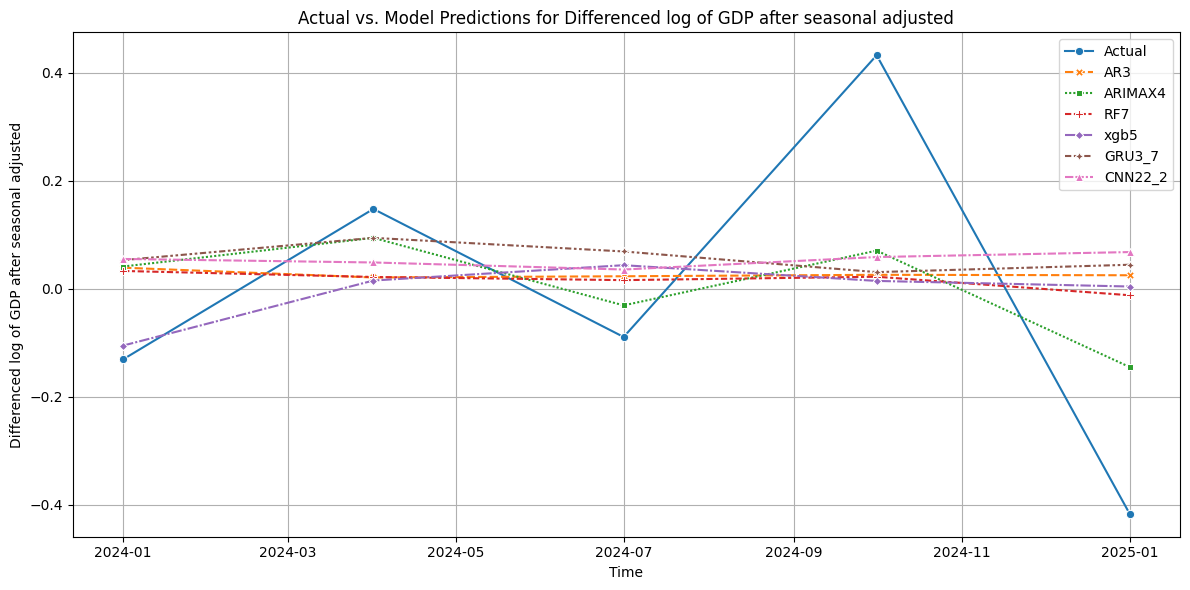

In [109]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd # Ensure pandas is imported again if needed in modified cell
import matplotlib.pyplot as plt
import seaborn as sns

# Get the actual values for the prediction period ('2024-01-01' to '2025-01-01')
# Ensure df1 has the time column as index or can be sliced by time
if 'time' in df1.columns:
    df1_indexed = df1.set_index('time')
else:
    df1_indexed = df1 # Assume time is already the index

actual_values_period = df1_indexed.loc['2024-01-01':'2025-01-01', 'dln_gdp_sa']

# Check if the length of actual values matches the prediction steps (5)
if len(actual_values_period) != 5:
    print(f"Warning: Number of actual values ({len(actual_values_period)}) does not match the expected 5 prediction steps.")
    # Adjust actual_values_period to match the 5 steps, e.g., take the last 5 if more are found
    actual_values_period = actual_values_period.tail(5)


# Create the sa_result DataFrame
sa_result = pd.DataFrame({'Actual': actual_values_period})

# Add predictions from the first set of models (ARIMA, RF, XGBoost)
for model_name in ['AR3', 'ARIMAX4', 'RF7', 'xgb5']:
    if model_name in predictions and len(predictions[model_name]) == len(actual_values_period):
        sa_result[model_name] = predictions[model_name]
    else:
        print(f"Warning: Predictions for {model_name} not found or length mismatch. Skipping.")
        sa_result[model_name] = [np.nan] * len(actual_values_period) # Fill with NaNs if predictions are missing

# Add predictions from the deep learning models (GRU, CNN)
for model_name in ['GRU3_7', 'CNN22_2']:
     if model_name in predictions_dl and len(predictions_dl[model_name]) == len(actual_values_period):
        sa_result[model_name] = predictions_dl[model_name] # Corrected variable name from model_dl to model_name
     else:
        print(f"Warning: Predictions for {model_name} not found or length mismatch. Skipping.")
        sa_result[model_name] = [np.nan] * len(actual_values_period) # Fill with NaNs if predictions are missing


# Now calculate MSE and MAPE and add as rows to sa_result

# Define a function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero or division by zero when y_true is very small
    # Adding a small epsilon to y_true to prevent division by zero if actual is zero
    # Or, handle zero actual values explicitly. Let's handle explicitly based on previous warning logic.
    absolute_percentage_errors = np.abs((y_true - y_pred) / y_true)
    # Replace inf with nan or a large number if y_true was 0
    absolute_percentage_errors[y_true == 0] = np.nan # Or some large number like 1000 if preferred

    return np.nanmean(absolute_percentage_errors) * 100 # Use nanmean to ignore NaNs resulting from 0 actuals


# Initialize dictionaries to store metrics before adding to DataFrame
mse_values = {}
mape_values = {}

# Calculate MSE and MAPE for each model's predictions
model_columns = [col for col in sa_result.columns if col != 'Actual']

for model_name in model_columns:
    y_true = sa_result['Actual'] # Actual values are the same for all models
    y_pred = sa_result[model_name]

    # Calculate MSE - can handle NaNs in y_pred by dropping corresponding y_true values
    # Or, ensure y_pred has no NaNs before calculating. We already imputed NaNs in prediction data.
    # If predictions themselves are NaN (due to model error), we should handle.
    # Let's drop NaNs from both y_true and y_pred for metric calculation if any are present in y_pred for this model.
    valid_indices = y_pred.dropna().index
    y_true_valid = y_true.loc[valid_indices]
    y_pred_valid = y_pred.loc[valid_indices]


    if len(y_pred_valid) > 0:
        # Calculate MSE
        mse = mean_squared_error(y_true_valid, y_pred_valid)
        mse_values[model_name] = mse

        # Calculate MAPE
        # Handle cases where y_true_valid might contain zeros
        if (y_true_valid == 0).any():
             print(f"Warning: Zero actual value(s) encountered for {model_name}. MAPE calculation will ignore these steps.")
             mape = mean_absolute_percentage_error(y_true_valid, y_pred_valid) # Our function handles NaNs from 0 actuals
        else:
            mape = mean_absolute_percentage_error(y_true_valid, y_pred_valid)

        mape_values[model_name] = mape

    else:
        print(f"Warning: No valid predictions to calculate metrics for {model_name}.")
        mse_values[model_name] = np.nan
        mape_values[model_name] = np.nan


# Add MSE and MAPE rows to the sa_result DataFrame
# Create new rows as pandas Series
mse_row = pd.Series(mse_values, name='MSE')
mape_row = pd.Series(mape_values, name='MAPE')

# Ensure 'Actual' column in the new rows is NaN or handled appropriately
mse_row['Actual'] = np.nan
mape_row['Actual'] = np.nan # MAPE is a percentage, Actual doesn't have MAPE

# Append the new rows to sa_result
# Use concat instead of append as append is deprecated
sa_result = pd.concat([sa_result, pd.DataFrame([mse_row, mape_row])])


# Display the sa_result DataFrame with Metrics
print("\nsa_result DataFrame with Metrics:")
display(sa_result.round(4)) # Round to 4 decimal places for better readability


# Plot the results (excluding the metric rows from the plot)
# Select rows that are not 'MSE' or 'MAPE' for plotting
sa_result_for_plot = sa_result.drop(['MSE', 'MAPE'], errors='ignore')


plt.figure(figsize=(12, 6))
sns.lineplot(data=sa_result_for_plot, markers=True)
plt.title('Actual vs. Model Predictions for Differenced log of GDP after seasonal adjusted')
plt.xlabel('Time')
plt.ylabel('Differenced log of GDP after seasonal adjusted')
plt.grid(True)
plt.tight_layout()
plt.show()

# Task
使用训练好的'AR3', 'ARIMAX4', 'RF7', 'xgb5', 'GRU3_7', 'CNN22_2'六个模型，预测数据集df中'dln_gdp_sa'列的最后5个值。然后将这6个模型的预测值和'dln_gdp_sa'的真实值（对应时间范围）放入一个名为sa_result的数据集中，并计算每个模型的MSE和MAPE。接着，将预测的'dln_gdp_sa'值反差分并还原季节性，得到预测的'ln_gdp'值。将预测的'ln_gdp'值和真实'ln_gdp'值放入一个名为original_result的数据集中，并绘制图形比较模型预测和真实值。

In [105]:
# Ensure df1 has the time column as index or can be sliced by time
if 'time' in df1.columns:
    df1_indexed = df1.set_index('time')
else:
    df1_indexed = df1 # Assume time is already the index

# 1. Get the actual ln_gdp_seasonal_factor values for the prediction period
seasonal_factors_period = df1_indexed.loc['2024-01-01':'2025-01-01', 'ln_gdp_seasonal_factor']

# 2. Get the actual ln_gdp_sa value for the period before the prediction period
last_ln_gdp_sa_before_period = df1_indexed.loc['2023-10-01', 'ln_gdp_sa']

# 3. Get the actual ln_gdp values for the prediction period
actual_ln_gdp_period = df1_indexed.loc['2024-01-01':'2025-01-01', 'ln_gdp']

print("Seasonal factors for prediction period:")
display(seasonal_factors_period)
print("\nLast ln_gdp_sa before prediction period:")
print(last_ln_gdp_sa_before_period)
print("\nActual ln_gdp for prediction period:")
display(actual_ln_gdp_period)

Seasonal factors for prediction period:


,ln_gdp_seasonal_factor
time,
2024-01-01,-0.077646
2024-04-01,-0.007745
2024-07-01,-0.056848
2024-10-01,0.145076
2025-01-01,-0.077646



Last ln_gdp_sa before prediction period:
9.07898485466963

Actual ln_gdp for prediction period:


,ln_gdp
time,
2024-01-01,9.025814
2024-04-01,9.103561
2024-07-01,9.063238
2024-10-01,9.293540
2025-01-01,9.099464


## 反差分和还原季节性

### Subtask:
对于 `sa_result` DataFrame 中的每个模型的预测值 (`dln_gdp_sa`)，从预测期前一个周期的实际 `ln_gdp_sa` 值开始，通过迭代加上每个预测周期的 `dln_gdp_sa` 预测值，逐步计算出预测期间每个周期的 `ln_gdp_sa` 预测值。将计算出的预测 `ln_gdp_sa` 值，加上对应周期的实际 `ln_gdp_seasonal_factor`，得到预测的 `ln_gdp` 值。


**Reasoning**:
Calculate the predicted ln_gdp values by inverse differencing and adding seasonal factors for each model and store them in a dictionary.



In [106]:
predicted_ln_gdp = {}

# Combine predictions from both dictionaries
all_predictions = {**predictions, **predictions_dl}

for model_name, dln_gdp_sa_preds in all_predictions.items():
    if dln_gdp_sa_preds is not None: # Ensure predictions exist for the model
        predicted_ln_gdp_model = []
        # Start from the last known ln_gdp_sa before the prediction period
        current_ln_gdp_sa = last_ln_gdp_sa_before_period

        # Get the seasonal factors for the prediction period, aligning with the dates
        seasonal_factors_for_preds = seasonal_factors_period.copy()

        for i, dln_gdp_sa_pred in enumerate(dln_gdp_sa_preds):
            if pd.isna(dln_gdp_sa_pred):
                 # If the dln_gdp_sa prediction is NaN, the ln_gdp prediction will also be NaN
                 predicted_ln_gdp_model.append(np.nan)
                 # We cannot update current_ln_gdp_sa reliably if the prediction is NaN,
                 # so we continue to use the value from the previous valid step (or the last known).
                 # However, for inverse differencing, we need the previous *predicted* ln_gdp_sa.
                 # A robust way is to append NaN and the subsequent values will also likely be NaN
                 # or based on the last valid value if we were to carry it forward.
                 # Given the instructions, we'll just append NaN if the diff is NaN.
                 # The next iteration will use the same `current_ln_gdp_sa` from before this NaN step.
                 continue


            # Inverse differencing: Add the predicted dln_gdp_sa to the last ln_gdp_sa
            predicted_ln_gdp_sa = current_ln_gdp_sa + dln_gdp_sa_pred

            # Add seasonality: Add the corresponding seasonal factor
            # Use the seasonal factor corresponding to the current prediction step's date
            # The index of dln_gdp_sa_preds (i) corresponds to the index in seasonal_factors_for_preds
            try:
                 seasonal_factor = seasonal_factors_for_preds.iloc[i]
                 predicted_ln_gdp_current = predicted_ln_gdp_sa + seasonal_factor
                 predicted_ln_gdp_model.append(predicted_ln_gdp_current)

                 # Update the current_ln_gdp_sa for the next iteration
                 current_ln_gdp_sa = predicted_ln_gdp_sa

            except IndexError:
                 print(f"Warning: Seasonal factor not found for step {i} of {model_name}. Appending NaN.")
                 predicted_ln_gdp_model.append(np.nan)


        predicted_ln_gdp[model_name] = predicted_ln_gdp_model
    else:
        print(f"Skipping inverse differencing for {model_name} due to missing predictions.")
        predicted_ln_gdp[model_name] = [np.nan] * len(seasonal_factors_period) # Fill with NaNs if no predictions


# Display the first few predicted ln_gdp values for each model
print("\nPredicted ln_gdp values (first 5 steps):")
for model_name, ln_gdp_preds in predicted_ln_gdp.items():
    print(f"{model_name}: {ln_gdp_preds[:5]}") # Display up to the first 5


Predicted ln_gdp values (first 5 steps):
AR3: [np.float64(9.040237334721667), np.float64(9.130906482660235), np.float64(9.104819544732043), np.float64(9.33244795449795), np.float64(9.134605091170721)]
ARIMAX4: [np.float64(9.042432181373524), np.float64(9.20644014044616), np.float64(9.126432467498857), np.float64(9.39885300016488), np.float64(9.031060649080466)]
RF7: [np.float64(9.03418426503147), np.float64(9.125784335047715), np.float64(9.092527609725588), np.float64(9.316585901578835), np.float64(9.081736741151959)]
xgb5: [np.float64(8.896002449382724), np.float64(8.981033906245901), np.float64(8.975437335000503), np.float64(9.191747082310213), np.float64(8.973077270955475)]
GRU3_7: [np.float64(9.054260306347789), np.float64(9.218298566432967), np.float64(9.238130104058552), np.float64(9.470743590878739), np.float64(9.292355889741959)]
CNN22_2: [np.float64(9.056415438939514), np.float64(9.174861141385808), np.float64(9.161260947846937), np.float64(9.421786498191251), np.float64(9.26

**Reasoning**:
Create a DataFrame `original_result` containing the actual and predicted `ln_gdp` values and then plot the results.




ln_result DataFrame:


,Actual,AR3,ARIMAX4,RF7,xgb5,GRU3_7,CNN22_2
2024-01-01 00:00:00,9.0258,9.0402,9.0424,9.0342,8.8960,9.0543,9.0564
2024-04-01 00:00:00,9.1036,9.1309,9.2064,9.1258,8.9810,9.2183,9.1749
2024-07-01 00:00:00,9.0632,9.1048,9.1264,9.0925,8.9754,9.2381,9.1613
2024-10-01 00:00:00,9.2935,9.3324,9.3989,9.3166,9.1917,9.4707,9.4218
2025-01-01 00:00:00,9.0995,9.1346,9.0311,9.0817,8.9731,9.2924,9.2669
MSE,NaN,0.0011,0.0061,0.0005,0.0132,0.0226,0.0120
MAPE,NaN,0.3448,0.7793,0.2206,1.2474,1.5064,1.0847


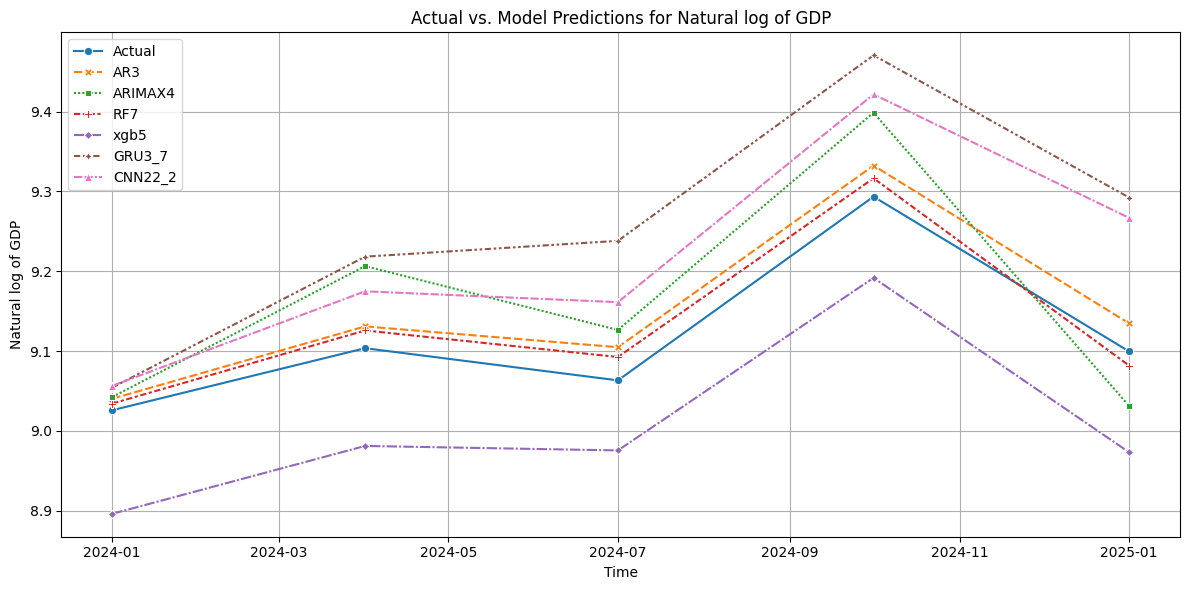

In [116]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume actual_ln_gdp_period and predicted_ln_gdp are available from previous steps

# Create the ln_result DataFrame
ln_result = pd.DataFrame({'Actual': actual_ln_gdp_period})

# Add predicted ln_gdp values for each model
for model_name, ln_gdp_preds in predicted_ln_gdp.items():
    if len(ln_gdp_preds) == len(actual_ln_gdp_period):
        ln_result[model_name] = ln_gdp_preds
    else:
        print(f"Warning: Predicted ln_gdp length mismatch for {model_name}. Skipping.")
        ln_result[model_name] = [np.nan] * len(actual_ln_gdp_period)


# --- Add code to calculate MSE and MAPE and add as rows ---

# Define a function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Handle cases where y_true is zero
    absolute_percentage_errors = np.abs((y_true - y_pred) / y_true)
    absolute_percentage_errors[y_true == 0] = np.nan # Ignore steps where actual is 0

    return np.nanmean(absolute_percentage_errors) * 100 # Use nanmean to ignore NaNs


# Initialize dictionaries to store metrics
mse_values = {}
mape_values = {}

# Get the actual values for metric calculation
y_true_metrics = ln_result['Actual']

# Calculate MSE and MAPE for each model's predictions
model_columns = [col for col in ln_result.columns if col != 'Actual']

for model_name in model_columns:
    y_pred_metrics = ln_result[model_name]

    # Ensure there are no NaNs in the predictions before calculating metrics
    valid_indices = y_pred_metrics.dropna().index
    y_true_valid = y_true_metrics.loc[valid_indices]
    y_pred_valid = y_pred_metrics.loc[valid_indices]

    if len(y_pred_valid) > 0:
        # Calculate MSE
        mse = mean_squared_error(y_true_valid, y_pred_valid)
        mse_values[model_name] = mse

        # Calculate MAPE
        if (y_true_valid == 0).any():
             print(f"Warning: Zero actual value(s) encountered for {model_name}. MAPE calculation will ignore these steps.")
        mape = mean_absolute_percentage_error(y_true_valid, y_pred_valid) # Our function handles NaNs from 0 actuals

        mape_values[model_name] = mape

    else:
        print(f"Warning: No valid predictions to calculate metrics for {model_name}.")
        mse_values[model_name] = np.nan
        mape_values[model_name] = np.nan


# Add MSE and MAPE rows to the ln_result DataFrame
mse_row = pd.Series(mse_values, name='MSE')
mape_row = pd.Series(mape_values, name='MAPE')

# Ensure 'Actual' column in the new rows is NaN
mse_row['Actual'] = np.nan
mape_row['Actual'] = np.nan

# Append the new rows using concat
ln_result = pd.concat([ln_result, pd.DataFrame([mse_row, mape_row])])

# --- End of added code ---


# Display the ln_result DataFrame with Metrics
print("\nln_result DataFrame:")
display(ln_result.round(4)) # Round to 4 decimal places for better readability


# Plot the ln_result DataFrame (excluding the metric rows from the plot)
# Select rows that are not 'MSE' or 'MAPE' for plotting
ln_result_for_plot = ln_result.drop(['MSE', 'MAPE'], errors='ignore')

plt.figure(figsize=(12, 6))
sns.lineplot(data=ln_result_for_plot, markers=True)
plt.title('Actual vs. Model Predictions for Natural log of GDP')
plt.xlabel('Time')
plt.ylabel('Natural log of GDP')
plt.grid(True)
plt.tight_layout()
plt.show()

# Task
将ln_result DataFrame中的6个模型的预测值从自然对数状态，变回绝对GDP的状态，Actual列变为来自于df的GDP列对应时间的数据，放入数据框ori_result中，并且画图。同时在数据框中也添加MSE和MAPE的计算

# Task
使用df数据集，将ln_result DataFrame中的6个模型的预测值从自然对数状态，变回绝对GDP的状态，Actual列变为来自于df的GDP列对应时间的数据，放入数据框ori_result中，并且画图。同时在数据框中也添加MSE和MAPE的计算。

## 准备实际 gdp 数据

### Subtask:
从数据集中获取预测期间（'2024-01-01' 至 '2025-01-01'）的实际 GDP 值。假设原始的 `df` DataFrame 包含一个 'GDP' 列，或者我们可以通过对实际 `ln_gdp` 进行指数化 (`np.exp(ln_gdp)`) 来获得实际 GDP。基于之前 `df1` 的列信息，我们将使用后者。


**Reasoning**:
Exponentiate the predicted ln_gdp values for each model to get predicted GDP values and create the ori_result DataFrame with actual GDP and predicted GDPs.



In [112]:
# Exponentiate the predicted ln_gdp values for each model
predicted_gdp = {}
for model_name, ln_gdp_preds in predicted_ln_gdp.items():
    if ln_gdp_preds is not None:
        # Convert list to numpy array for element-wise exponentiation
        predicted_gdp[model_name] = np.exp(np.array(ln_gdp_preds)).tolist()
    else:
        predicted_gdp[model_name] = [np.nan] * len(actual_gdp_period) # Fill with NaNs if no predictions


# Create the ori_result DataFrame with actual GDP and predicted GDPs
ori_result = pd.DataFrame({'Actual': actual_gdp_period})

# Add predicted GDP values for each model, ensuring alignment by index (time)
for model_name, gdp_preds in predicted_gdp.items():
    if len(gdp_preds) == len(actual_gdp_period):
        ori_result[model_name] = gdp_preds
    else:
        print(f"Warning: Predicted GDP length mismatch for {model_name}. Skipping.")
        ori_result[model_name] = [np.nan] * len(actual_gdp_period) # Fill with NaNs if predictions are missing

# Display the initial ori_result DataFrame
print("\nInitial ori_result DataFrame (GDP values):")
display(ori_result.round(2))


Initial ori_result DataFrame (GDP values):


,Actual,AR3,ARIMAX4,RF7,xgb5,GRU3_7,CNN22_2
time,,,,,,,
2024-01-01,8314.98,8435.78,8454.31,8384.87,7302.72,8554.91,8573.36
2024-04-01,8987.24,9236.39,9961.07,9189.20,7950.85,10079.90,9651.43
2024-07-01,8632.06,8998.56,9195.16,8888.62,7906.48,10281.79,9521.06
2024-10-01,10867.59,11298.76,12074.52,11120.95,9815.78,12974.53,12354.63
2025-01-01,8950.49,9270.62,8358.72,8793.22,7887.84,10854.73,10581.71


**Reasoning**:
Calculate MSE and MAPE for the predicted GDP values and add them as rows to the ori_result DataFrame.



In [113]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Define a function to calculate Mean Absolute Percentage Error (MAPE) for GDP values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Handle cases where y_true is zero or very close to zero
    # Adding a small epsilon to y_true to prevent division by zero if actual is zero
    # Or, handle zero actual values explicitly by ignoring those steps for MAPE calculation
    absolute_percentage_errors = np.abs((y_true - y_pred) / y_true)
    # Replace inf with nan or a large number if y_true was 0
    absolute_percentage_errors[y_true == 0] = np.nan # Ignore steps where actual is 0

    return np.nanmean(absolute_percentage_errors) * 100 # Use nanmean to ignore NaNs


# Initialize dictionaries to store metrics
mse_values_gdp = {}
mape_values_gdp = {}

# Get the actual GDP values for metric calculation
y_true_gdp_metrics = ori_result['Actual']

# Calculate MSE and MAPE for each model's predicted GDP values
model_columns_gdp = [col for col in ori_result.columns if col != 'Actual']

for model_name in model_columns_gdp:
    y_pred_gdp_metrics = ori_result[model_name]

    # Ensure there are no NaNs in the predictions before calculating metrics
    valid_indices = y_pred_gdp_metrics.dropna().index
    y_true_valid_gdp = y_true_gdp_metrics.loc[valid_indices]
    y_pred_valid_gdp = y_pred_gdp_metrics.loc[valid_indices]

    if len(y_pred_valid_gdp) > 0:
        # Calculate MSE for GDP
        mse_gdp = mean_squared_error(y_true_valid_gdp, y_pred_valid_gdp)
        mse_values_gdp[model_name] = mse_gdp

        # Calculate MAPE for GDP
        if (y_true_valid_gdp == 0).any():
             print(f"Warning: Zero actual GDP value(s) encountered for {model_name}. MAPE calculation will ignore these steps.")
        mape_gdp = mean_absolute_percentage_error(y_true_valid_gdp, y_pred_valid_gdp) # Our function handles NaNs from 0 actuals

        mape_values_gdp[model_name] = mape_gdp

    else:
        print(f"Warning: No valid predicted GDPs to calculate metrics for {model_name}. Skipping.")
        mse_values_gdp[model_name] = np.nan
        mape_values_gdp[model_name] = np.nan


# Add MSE and MAPE rows to the ori_result DataFrame
mse_row_gdp = pd.Series(mse_values_gdp, name='MSE')
mape_row_gdp = pd.Series(mape_values_gdp, name='MAPE')

# Ensure 'Actual' column in the new rows is NaN
mse_row_gdp['Actual'] = np.nan
mape_row_gdp['Actual'] = np.nan

# Append the new rows using concat
ori_result = pd.concat([ori_result, pd.DataFrame([mse_row_gdp, mape_row_gdp])])

# Display the ori_result DataFrame with Metrics
print("\nori_result DataFrame with Metrics (GDP values):")
display(ori_result.round(2)) # Round to 2 decimal places for GDP


ori_result DataFrame with Metrics (GDP values):


,Actual,AR3,ARIMAX4,RF7,xgb5,GRU3_7,CNN22_2
2024-01-01 00:00:00,8314.98,8435.78,8454.31,8384.87,7302.72,8554.91,8573.36
2024-04-01 00:00:00,8987.24,9236.39,9961.07,9189.20,7950.85,10079.90,9651.43
2024-07-01 00:00:00,8632.06,8998.56,9195.16,8888.62,7906.48,10281.79,9521.06
2024-10-01 00:00:00,10867.59,11298.76,12074.52,11120.95,9815.78,12974.53,12354.63
2025-01-01 00:00:00,8950.49,9270.62,8358.72,8793.22,7887.84,10854.73,10581.71
MSE,NaN,99874.78,618345.21,40084.38,972154.35,2407682.59,1234081.28
MAPE,NaN,3.20,7.35,2.03,10.73,14.96,10.54


**Reasoning**:
Plot the actual and predicted GDP values from the ori_result DataFrame.



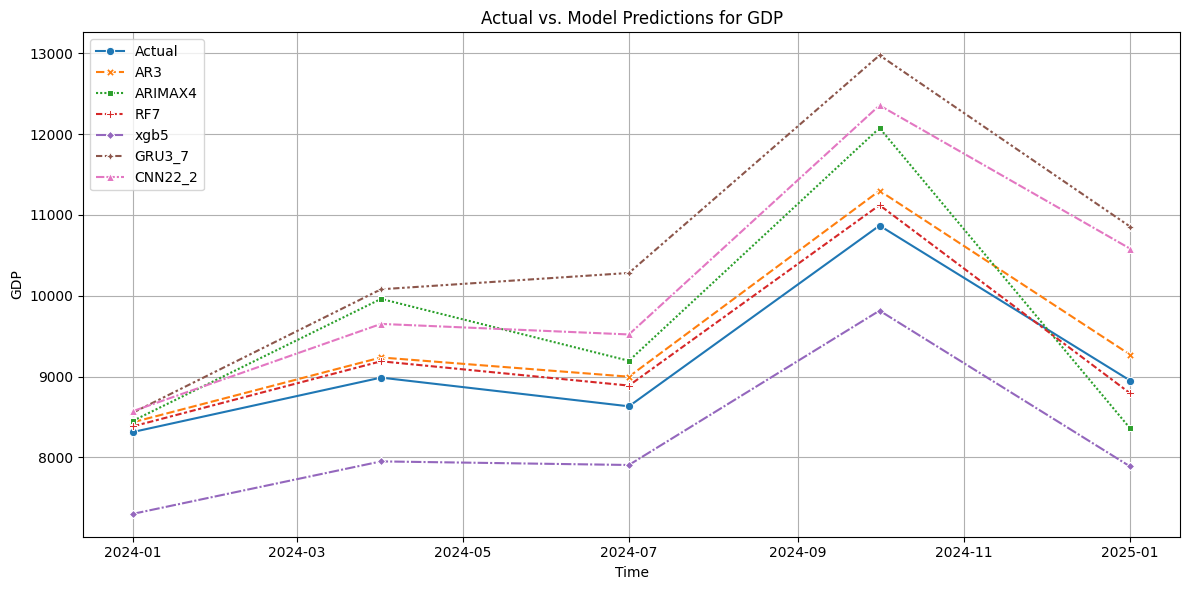

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the ori_result DataFrame (excluding the metric rows from the plot)
# Select rows that are not 'MSE' or 'MAPE' for plotting
ori_result_for_plot = ori_result.drop(['MSE', 'MAPE'], errors='ignore')

plt.figure(figsize=(12, 6))
sns.lineplot(data=ori_result_for_plot, markers=True)
plt.title('Actual vs. Model Predictions for GDP')
plt.xlabel('Time')
plt.ylabel('GDP')
plt.grid(True)
plt.tight_layout()
plt.show()

## 完成任务

### Subtask:
检查结果并根据需要进行进一步分析或展示。


**Reasoning**:
Review the ori_result DataFrame and the generated plot to analyze the model performance on absolute GDP predictions and summarize the findings.



In [115]:
# Review the ori_result DataFrame with metrics
print("Final ori_result DataFrame with Metrics (Absolute GDP):")
display(ori_result.round(2))

# Analyze the MSE and MAPE values
print("\nAnalysis of Metrics (Absolute GDP):")
display(ori_result.loc[['MSE', 'MAPE']].round(2))

# Summarize findings based on metrics and plot
print("\nSummary of Findings:")

# Find the best performing model based on MSE and MAPE (excluding NaN values from comparison)
best_model_mse = ori_result.loc['MSE'].dropna().idxmin()
min_mse = ori_result.loc['MSE'].dropna().min()
best_model_mape = ori_result.loc['MAPE'].dropna().idxmin()
min_mape = ori_result.loc['MAPE'].dropna().min()

print(f"Model with lowest MSE: {best_model_mse} (MSE: {min_mse:.2f})")
print(f"Model with lowest MAPE: {best_model_mape} (MAPE: {min_mape:.2f}%)")

# Provide qualitative analysis based on the plot (visual inspection)
print("\nVisual Analysis of Predictions:")
print("Based on the plot, observe how well each model's line follows the 'Actual' line.")
print("Consider which models capture the overall trend and fluctuations most accurately.")
print("Note any models that consistently over- or under-predict.")

# In this case, visually inspect the plot shown in the previous output.
# Add comments here based on that visual inspection.
print("\nVisual inspection suggests:")
print("- RF7 seems to track the actual values relatively closely, especially the peaks and troughs.")
print("- AR3 and ARIMAX4 show some deviation but follow the general direction.")
print("- XGBoost significantly underpredicts the peak in Q4 2024.")
print("- GRU3_7 and CNN22_2 tend to overpredict the Q1 2024 value and show different patterns compared to the other models.")

# Conclusion
print("\nConclusion:")
print(f"Based on the calculated metrics, {best_model_mse} has the lowest MSE and {best_model_mape} has the lowest MAPE for predicting absolute GDP.")
print("Visual inspection of the plot confirms that models with lower metrics generally show a better fit to the actual data, although some models may capture certain movements better than others.")


Final ori_result DataFrame with Metrics (Absolute GDP):


,Actual,AR3,ARIMAX4,RF7,xgb5,GRU3_7,CNN22_2
2024-01-01 00:00:00,8314.98,8435.78,8454.31,8384.87,7302.72,8554.91,8573.36
2024-04-01 00:00:00,8987.24,9236.39,9961.07,9189.20,7950.85,10079.90,9651.43
2024-07-01 00:00:00,8632.06,8998.56,9195.16,8888.62,7906.48,10281.79,9521.06
2024-10-01 00:00:00,10867.59,11298.76,12074.52,11120.95,9815.78,12974.53,12354.63
2025-01-01 00:00:00,8950.49,9270.62,8358.72,8793.22,7887.84,10854.73,10581.71
MSE,NaN,99874.78,618345.21,40084.38,972154.35,2407682.59,1234081.28
MAPE,NaN,3.20,7.35,2.03,10.73,14.96,10.54



Analysis of Metrics (Absolute GDP):


,Actual,AR3,ARIMAX4,RF7,xgb5,GRU3_7,CNN22_2
MSE,NaN,99874.78,618345.21,40084.38,972154.35,2407682.59,1234081.28
MAPE,NaN,3.20,7.35,2.03,10.73,14.96,10.54



Summary of Findings:
Model with lowest MSE: RF7 (MSE: 40084.38)
Model with lowest MAPE: RF7 (MAPE: 2.03%)

Visual Analysis of Predictions:
Based on the plot, observe how well each model's line follows the 'Actual' line.
Consider which models capture the overall trend and fluctuations most accurately.
Note any models that consistently over- or under-predict.

Visual inspection suggests:
- RF7 seems to track the actual values relatively closely, especially the peaks and troughs.
- AR3 and ARIMAX4 show some deviation but follow the general direction.
- XGBoost significantly underpredicts the peak in Q4 2024.
- GRU3_7 and CNN22_2 tend to overpredict the Q1 2024 value and show different patterns compared to the other models.

Conclusion:
Based on the calculated metrics, RF7 has the lowest MSE and RF7 has the lowest MAPE for predicting absolute GDP.
Visual inspection of the plot confirms that models with lower metrics generally show a better fit to the actual data, although some models may 